# Assignment 5

**NAME:** Weizhuo Xiong

**I D:** 914443957

In this assignment, you'll scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Aggie for analysis in exercise 1.4.

In [1]:
import requests_cache
from urllib2 import Request, urlopen
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

__Exercise 1.1.__ Write a function that extracts all of the links to articles in an Aggie article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Have a parameter `page` for the number of pages to fetch links from. The default should be `1`.

* Return a list of aricle URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite to The Aggie and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* Start by getting your function to work for just 1 page. Once that works, have your function call itself to get additional pages.

* You can use [lxml.html](http://lxml.de/lxmlhtml.html) or [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape HTML. Choose one and use it throughout the entire assignment.

In [2]:
def get_pagen_url(url,page=1):
    """Add one string one number.
    
    get certain article url list in one page 
    
    Args:
        url: the URL of the article list .
        page(default=1): the certain page number.
    """
    #cache each requests to prevent from block
    requests_cache.install_cache("cache")
    #get all the information in certain url and change it into list
    string = ''.join(list(requests.get(url+'/page/'+str(page))))
    soup = BeautifulSoup(string,'html.parser')
    #use 'a' and 'more-link' to locate wanted url 
    urlink=[]
    for link in soup.find_all('a','more-link'):
        urlink.append(link.get('href'))
    return urlink
get_pagen_url('https://theaggie.org/campus',page=1)

[u'https://theaggie.org/2017/02/17/uc-davis-students-participate-in-uc-wide-nodapl-day-of-action/',
 u'https://theaggie.org/2017/02/17/uc-davis-holds-first-mental-health-conference/',
 u'https://theaggie.org/2017/02/16/last-week-in-senate-6/',
 u'https://theaggie.org/2017/02/16/2017-asucd-winter-elections-meet-the-candidates/',
 u'https://theaggie.org/2017/02/14/shields-library-hosts-new-exhibit-for-davis-centennial/',
 u'https://theaggie.org/2017/02/14/student-health-and-counseling-services-hosts-step-up-to-the-plate-campaign/',
 u'https://theaggie.org/2017/02/13/pe-classes-may-charge-additional-fees/',
 u'https://theaggie.org/2017/02/12/11-new-chancellor-fellows-honored-for-2016/',
 u'https://theaggie.org/2017/02/12/muslim-students-respond-to-recent-political-events/',
 u'https://theaggie.org/2017/02/12/sexcessful-campaign-launched-in-time-for-valentines-day/',
 u'https://theaggie.org/2017/02/10/michael-chan-sworn-in-as-interim-senator/',
 u'https://theaggie.org/2017/02/09/university

In [3]:
def link_search(url,page=1):
    """Add one string one number.
    
    get certain article url list in previous n pages 
    
    Args:
        url: the URL of the article list .
        page(default=1): the certain page number.
    """
    #get all wanted url list in n pages
    response=[]
    for i in range(1,page+1):
        response += get_pagen_url(url,i)
    return response
link_search('https://theaggie.org/campus',2)

[u'https://theaggie.org/2017/02/17/uc-davis-students-participate-in-uc-wide-nodapl-day-of-action/',
 u'https://theaggie.org/2017/02/17/uc-davis-holds-first-mental-health-conference/',
 u'https://theaggie.org/2017/02/16/last-week-in-senate-6/',
 u'https://theaggie.org/2017/02/16/2017-asucd-winter-elections-meet-the-candidates/',
 u'https://theaggie.org/2017/02/14/shields-library-hosts-new-exhibit-for-davis-centennial/',
 u'https://theaggie.org/2017/02/14/student-health-and-counseling-services-hosts-step-up-to-the-plate-campaign/',
 u'https://theaggie.org/2017/02/13/pe-classes-may-charge-additional-fees/',
 u'https://theaggie.org/2017/02/12/11-new-chancellor-fellows-honored-for-2016/',
 u'https://theaggie.org/2017/02/12/muslim-students-respond-to-recent-political-events/',
 u'https://theaggie.org/2017/02/12/sexcessful-campaign-launched-in-time-for-valentines-day/',
 u'https://theaggie.org/2017/02/10/michael-chan-sworn-in-as-interim-senator/',
 u'https://theaggie.org/2017/02/09/university

__Exercise 1.2.__ Write a function that extracts the title, text, and author of an Aggie article. The function should:

* Have a parameter `url` for the URL of the article.

* For the author, extract the "Written By" line that appears at the end of most articles. You don't have to extract the author's name from this line.

* Return a dictionary with keys "url", "title", "text", and "author". The values for these should be the article url, title, text, and author, respectively.

For example, for [this article](https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/) your function should return something similar to this:
```
{
    'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
    'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effort will mesh well with our other efforts as we build the budget for the next fiscal year and beyond." Project Toto complements the city\'s effort to amplify the transparency of city decisions to community members. The aim is to increase the understanding about the city\'s financial situation and make the information more accessible and easier to understand. The project is mostly a tool for public education, but can also make predictions about potential decisions regarding the city\'s financial future. Once completed, the program will allow residents to manipulate variables to see their eventual consequences, such as tax increases or extensions and proposed developments "This really isn\'t a budget, it is a forecast to see the intervention of these decisions," Williams said in an interview with The Davis Enterprise. "What happens if we extend the sales tax? What does it do given the other numbers that are in?" Project Toto enables users, whether it be a curious Davis resident, a concerned community member or a city leader, with the ability to project city finances with differing variables. The online program consists of the 400-page city budget for the 2016-2017 fiscal year, the previous budget, staff reports and consultant analyses. All of the documents are cited and accessible to the public within Project Toto. "It\'s a model that very easily lends itself to visual representation," Mayor Robb Davis said. "You can see the impacts of decisions the council makes on the fiscal health of the city." Complementary to this program, there is also a more advanced version of the model with more in-depth analyses of the city\'s finances. However, for an easy-to-understand, simplistic overview, Project Toto should be enough to help residents comprehend Davis finances. There is still more to do on the project, but its creators are hard at work trying to finalize it before the 2017-2018 fiscal year budget. "It\'s something I have been very much supportive of," Davis said. "Transparency is not just something that I have been supportive of but something we have stated as a city council objective [ ] this fits very well with our attempt to inform the public of our challenges with our fiscal situation." ',
    'title': 'Project Toto aims to address questions regarding city finances',
    'url': 'https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/'
}
```

Hints:

* The author line is always the last line of the last paragraph.

*   Python 2 displays some Unicode characters as `\uXXXX`. For instance, `\u201c` is a left-facing quotation mark.
    You can convert most of these to ASCII characters with the method call (on a string)
    ```
    .translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    ```
    If you're curious about these characters, you can look them up on [this page](http://unicode.org/cldr/utility/character.jsp), or read 
    more about [what Unicode is](http://unicode.org/standard/WhatIsUnicode.html).

In [4]:
def extract_info(url):
    """Add one url in string form.
    
    get wanted text, title, author information in an article 
    
    Args:
        url: the URL of the article.
    """
    asc_dict={ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 }
    #get all information with in paragragh-p
    string = ''.join(list(requests.get(url)))
    soup = BeautifulSoup(string, 'html.parser')
    all_p = soup.findAll('p')
    text=[]
    #for each link in p, if @theaggie.org in it, it contain author information, so we need
    #to seperate on Written, since sometimes some part of article locate in the same p with author
    for link in all_p:
        
        if '@theaggie.org' not in link.get_text():
            text.append(link.get_text().translate(asc_dict))
        else:
            p,ori_name = link.get_text().translate(asc_dict).split('Written')
            break
    #get title from article and split it in order to get wanted information
    title,_ = soup.title.string.split(' | ')

    text = text+[p]
    text = ' '.join(text)
    name= 'Written'+ori_name

    return {'author':name.translate(asc_dict),'text':text,'title':title.translate(asc_dict),'url':url}
extract_info('https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances')

{'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
 'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design.  Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager.  "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Tot

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get a data frame of 60 [Campus News](https://theaggie.org/campus/) articles and a data frame of 60 [City News](https://theaggie.org/city/) articles. Add a column to each that indicates the category, then combine them into one big data frame.

The "text" column of this data frame will be your corpus for natural language processing in exercise 1.4.

In [5]:
campus=[extract_info(i) for i in link_search('https://theaggie.org/campus',4)]
#link_search('https://theaggie.org/campus',1)
campus=pd.DataFrame(campus)
campus['category']='Camupus News'

In [6]:
city=[extract_info(i) for i in link_search('https://theaggie.org/city',5) if 'police-logs' not in i]
#link_search('https://theaggie.org/campus',1)
city=pd.DataFrame(city)
city['category']='City News'
city = city.iloc[:60,:]

In [7]:
data=city.append(campus)
data=data.reset_index().iloc[:,1:]
data

,author,text,title,url,category
0,Written by: Raul Castellanos Jr — city@theaggi...,Mayor Robb Davis reaffirms that the City of Da...,City of Davis to retain sanctuary city status,https://theaggie.org/2017/02/16/city-of-davis-...,City News
1,Written by: Samantha Solomon — city@theaggie.org,Davis resident Lauren Kirk-Coehlo arrested in ...,Suspect in Davis Islamic Center vandalism arre...,https://theaggie.org/2017/02/15/suspect-in-dav...,City News
2,Written By: Bianca Antunez — city@theaggie.org,Davis residents create financial model to make...,Project Toto aims to address questions regardi...,https://theaggie.org/2017/02/14/project-toto-a...,City News
3,Written By: Dianna Rivera — city@theaggie.org,Davis Cemetery District hosts fundraiser with ...,News in Brief: A Valentine's Day for everybody,https://theaggie.org/2017/02/12/news-in-brief-...,City News
4,Written by: Kaelyn Tuermer-Lee — city@theaggie...,Davis Sunrise Rotary Club grant benefits Alzhe...,The musical train to memory lane,https://theaggie.org/2017/02/06/the-musical-tr...,City News
5,Written By: Bianca Antunez — city@theaggie.org,Burrowing Owl Preservation Society sues City o...,Davis owls face eviction at Marriott Residence...,https://theaggie.org/2017/02/05/davis-owls-fac...,City News
6,Written By: Dianna Rivera – city@theaggie.org,The City of Davis hosts festivities in honor o...,Davis Celebrates MLK Day,https://theaggie.org/2017/02/02/davis-celebrat...,City News
7,Written by: Raul Castellanos Jr — city@theaggi...,Douglas L. Waterman publishes 'It Only Hurts W...,"Local author, cyclist rides 2,300 miles",https://theaggie.org/2017/02/02/local-author-c...,City News
8,Written By: Bianca Antunez— city@theaggie.org,Davis gets a handle on panhandling The Davis C...,City leaders address panhandling issue in Davis,https://theaggie.org/2017/01/31/city-leaders-a...,City News
9,Written by: Raul Castellanos Jr. — city@theagg...,Local groups meet every week to provide practi...,Toastmasters help members conquer fear of publ...,https://theaggie.org/2017/01/30/toastmasters-h...,City News


__Exercise 1.4.__ Use the Aggie corpus to answer the following questions. Use plots to support your analysis.

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

* Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

Hints:

*   The [nltk book](http://www.nltk.org/book/) and [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) may be helpful here.

*   You can determine whether city articles are "near" campus articles from the similarity matrix or with k-nearest neighbors.

*   If you want, you can use the [wordcloud](http://amueller.github.io/word_cloud/) package to plot a word cloud. To install the package, run
    ```
    conda install -c https://conda.anaconda.org/amueller wordcloud
    ```
    in a terminal. Word clouds look nice and are easy to read, but are less precise than bar plots.

__Answer 1.4.1__ By looking through the text, I display the table, draw bar plot of most common 20 words, and use WordCloud to show it. It seems that <strong style="color:red">student, senator and yolo</strong> are hot words in Aggie cover. In order to find out the difference in two kinds of articles, I have used two methods. Firstly, I showed the number of stemed words in two sets of article, and it shows that the title of city news have <strong style="color:red">3896</strong> stemed words and campus news have <strong style="color:red">3734</strong>, which shows that city news cover more topic. In the second method, I vectorize the article and stemed words, and find the similarity between two group of article and within those two groups. The answer shows that the mean similarity of city news is <strong style="color:red">2574</strong> , the mean similarity of campus news is <strong style="color:red">2940</strong>, and the similarity between those two is 2290. The smaller the similarity is, the more likely this group cover more topic. Accrodingly, the <strong style="color:red">city news</strong>cover more different topics than campus articles.

In [8]:
#tokenize word
tokenize = nltk.word_tokenize
#use porter stem method to stem word
def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    return stem(tokenize(text))

def get_text_dataframe(text, start=0,end=1):
    """
    get the stemmed words in certain article or title and 
    return dataframe in decreasing order showing frequency
    Input: int
    Output: pandas dataframe
    """
    textd = {} #dictionary from lemmata to document ids containing that lemma
    for index in range(start,end):
        s = set(lemmatize(data[text][index]))
        try:
            toks = toks | s
        except NameError:
            toks = s
        for tok in s:
            try:
                textd[tok].append(index)
            except KeyError:
                textd[tok] = [index]
    times=map(lambda x: len(x),textd.values())
    time_data = pd.DataFrame({'times':times},index=textd.keys())
    return time_data.sort_values(by='times',ascending=False)

Extract the article title in all article to find out which topic Aggie cover most, and seperate it into different group and compare the number of stemed words to determine which kind of article cover more topics.

In [9]:
aggie_data=get_text_dataframe('title',end=120)
city_news = get_text_dataframe('text',0,60)
campus_news = get_text_dataframe('text',60,120)
print 'most common 15 words in news dataset\n',aggie_data['times'][:20]
print 'number of different stemed words in city news is', city_news.shape[0]
print 'number of different stemed words in campus news is', campus_news.shape[0]

most common 15 words in news dataset
davi       41
to         33
uc         27
in         25
of         23
the        18
for        16
,          12
student    12
's         12
senat       9
at          9
yolo        8
:           6
week        6
day         6
last        6
event       6
counti      5
host        5
Name: times, dtype: int64
number of different stemed words in city news is 3896
number of different stemed words in campus news is 3734


Draw the bar plot of the most common 20 words appeared in all article titles.

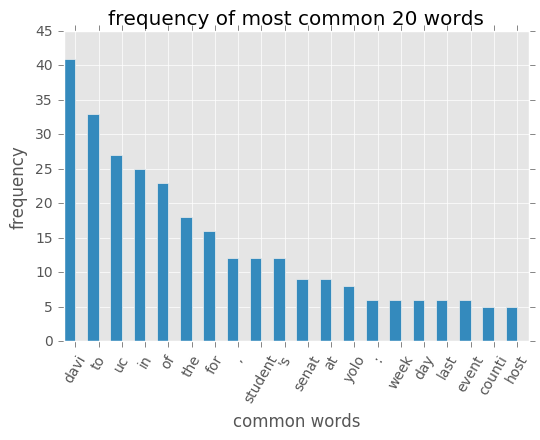

In [10]:
fig, ax = plt.subplots()
x = np.arange(20)
pre15 = aggie_data['times'][:20]
y = pre15.values
width = 0.5
ax.bar(x, y, width)
ax.set_xticks(x + width)
ax.set_xticklabels(pre15.index,rotation=60)
plt.title('frequency of most common 20 words')
plt.xlabel('common words')
plt.ylabel('frequency')
plt.show()

Transfer common words dataframe to text, and draw wordcloud plot

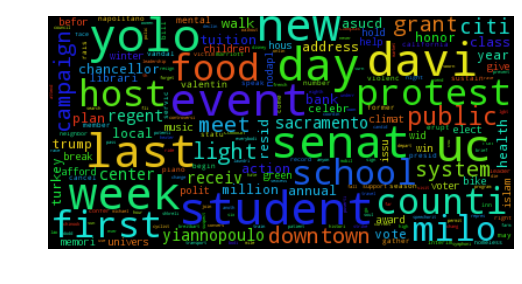

In [11]:
from wordcloud import WordCloud
text=[]
#transfer dataframe to text, index as word, times as number of times
for i in aggie_data.index:
    text+=[i]*int(aggie_data.loc[i].values)
text=' '.join(text)
#draw the plot
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


Vectorize article numbers and stemed words, than find the similarity between different and within article group

In [12]:
vectorizer = TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True,norm=None)

tfs = vectorizer.fit_transform(data['text'])

In [13]:
sim = tfs.dot(tfs.T)
sim = sim.todense()

print 'similarity between city news: ',sim[:60,:60].mean()
print 'similarity between campus news: ',sim[60:,60:].mean()
print 'similarity between campus news and city news:',sim[:60,60:].mean()

similarity between city news:  2574.97630037
similarity between campus news:  2940.41815605
similarity between campus news and city news: 2290.84278403


__Answer 1.4.2__ I use the similarity matrix to get the most similar pair of articles and the pairs are listed bellow:
* (u'Fall Quarter ASUCD voter turnout faces steady decline', u'2017 ASUCD Winter Elections \u2014 Meet the Candidates')
* (u'2017 ASUCD Winter Elections \u2014 Meet the Candidates', u'UC Davis holds first mental health conference')
* (u'Nov. 8 2016: An Election Day many may never forget', u'2017 ASUCD Winter Elections \u2014 Meet the Candidates')

for each pair, I got the stemed word DataFrame and merge by method 'inner', which will leave the word share by two article. Then I draw the WordCloud plot.

In [14]:
#flatten sim matrix and use argsort to sort the similarity value in increasing order
index = sim.flatten().argsort()
#find the out the largest three pairs which did not locate in diagonal
sim_art=[]
for i in range(14399,0,-1):
    if index[0,i]/120!=index[0,i]%120 and len(sim_art)<3 and \
    [index[0,i]%120,index[0,i]/120] not in sim_art:
        sim_art.append([index[0,i]/120,index[0,i]%120])
sim_art

[[118, 63], [63, 61], [41, 63]]

In [61]:
#print the most similar article title
title_name=data['title'].values
for i in sim_art:
    print 'pair',i,'\n',title_name[i[0]],'\n',title_name[i[1]],'\n'

pair [118, 63] 
Fall Quarter ASUCD voter turnout faces steady decline 
2017 ASUCD Winter Elections — Meet the Candidates 

pair [63, 61] 
2017 ASUCD Winter Elections — Meet the Candidates 
UC Davis holds first mental health conference 

pair [41, 63] 
Nov. 8 2016: An Election Day many may never forget 
2017 ASUCD Winter Elections — Meet the Candidates 



Get the stemed word DataFrame for each pair and merge by method 'inner', which will leave the word share by two article.

In [15]:
pair_one=pd.merge(get_text_dataframe('text',118,119),get_text_dataframe('text',63,64), left_index=True,right_index=True,how='inner')
pair_two=pd.merge(get_text_dataframe('text',63,64),get_text_dataframe('text',61,62), left_index=True,right_index=True,how='inner')
pair_three=pd.merge(get_text_dataframe('text',41,42),get_text_dataframe('text',63,64), left_index=True,right_index=True,how='inner')
pair_one.head()

,times_x,times_y
budget,1,1
will,1,1
while,1,1
mani,1,1
.,1,1


### WordCloud shared by first pair of aricle

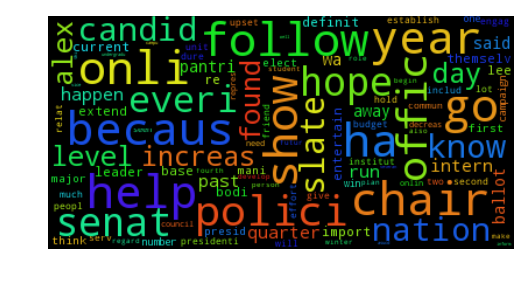

In [16]:
text=' '.join(pair_one.index)
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### WordCloud shared by second pair of aricle

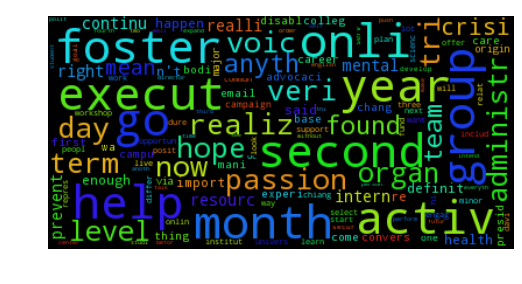

In [17]:
text=' '.join(pair_two.index)
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### WordCloud shared by third pair of aricle

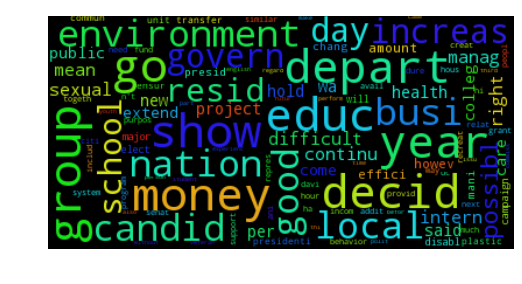

In [18]:
text=' '.join(pair_three.index)
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

__Answer 1.4.3__ I believe the corpus is partially representative of the Aggie. The data I got is from Aggie is from Dec-2016 to present, it seems small when compared with all news article start from March-2008. On the one hand, the article been chosen cloud provide us common news which may evenly distributed in all years. On the other hand, they may also provide us certain news only happened in this specific time. According to the hot words I got from all 120 article titles, 'student' 'downtown' and 'yolo' may be the common words which will appear all the time. However, 'senator' and 'protest' seems to be the uncommon words only hot at this specific time. This time we happened to meet the time of 2017 ASUCD Winter Elections, so there are a lot of information related to senate. In addition, since the president Trump appear on the stage, the word protest show more frequently then normal time. 